<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/Density_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import heapq
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN


In [9]:
seed = 0

In [10]:
def k_means(X, k, max_iter=300, tol=1e-4):

    # Step 1: Initialize centroids randomly from the dataset
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed)
    centroids = X[rng.choice(n_samples, k, replace=False)]

    for _ in range(max_iter):
        # Step 2: Assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)

        # Step 3: Compute new centroids
        new_centroids = np.array([X[cluster_assignments == j].mean(axis=0) if np.any(cluster_assignments == j) else centroids[j]
                                  for j in range(k)])

        # Step 4: Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return cluster_assignments, centroids


# DBSCAN


In [4]:
import pdb
import sys

def dbscan_base(df, eps, MinPts):
    # Extract the features (excluding the target)
    # D = df.drop(['target', 'species', 'dbscan_predictions'], axis=1).values
    D = df
    # Mark all points as unvisited
    n = len(D)
    visited = [False] * n
    clusters = []
    noise = []




    for i in range(n):
        if not visited[i]:
            visited[i] = True
            neighbors = region_query(D, i, eps)

            if len(neighbors) < MinPts:
                noise.append(i)
            else:
                cluster = []
                expand_cluster(D, i, neighbors, cluster, eps, MinPts, visited)
                clusters.append(cluster)


    cluster_labels = generate_cluster_labels(D, clusters, noise)
    print(clusters)
    return clusters, noise, cluster_labels

def expand_cluster(D, P, neighbors, cluster, eps, MinPts, visited):
    cluster.append(P)
    i = 0
    while i < len(neighbors):
        Q = neighbors[i]
        if not visited[Q]:
            visited[Q] = True
            Q_neighbors = region_query(D, Q, eps)
            if len(Q_neighbors) >= MinPts:
                neighbors += Q_neighbors
        if Q not in cluster:
            cluster.append(Q)
        i += 1

def region_query(D, P, eps):
    neighbors = []
    for i in range(len(D)):
        if euclidean(D[P], D[i]) < eps:
            neighbors.append(i)
    return neighbors

def generate_cluster_labels(D, clusters, noise):
    cluster_labels = np.full(len(D), -1)
    print(len(cluster_labels))
    for i in range(0,len(clusters)):
        for x in clusters[i]:
            cluster_labels[x] = i

    for x in noise:
        cluster_labels[x] = -1

    return cluster_labels




In [74]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

print("Iris Dataset\n")

start_time = time.time()
cluters, noise, labels_base_iris = dbscan_base(X_iris, 0.5, 5)
print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_iris, labels_base_iris)}")

start_time = time.time()
dbscan_iris = DBSCAN().fit(X_iris)

labels_sklearn_iris = dbscan_iris.labels_
print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_iris, labels_sklearn_iris)}")

Iris Dataset

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.1 1.5 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5

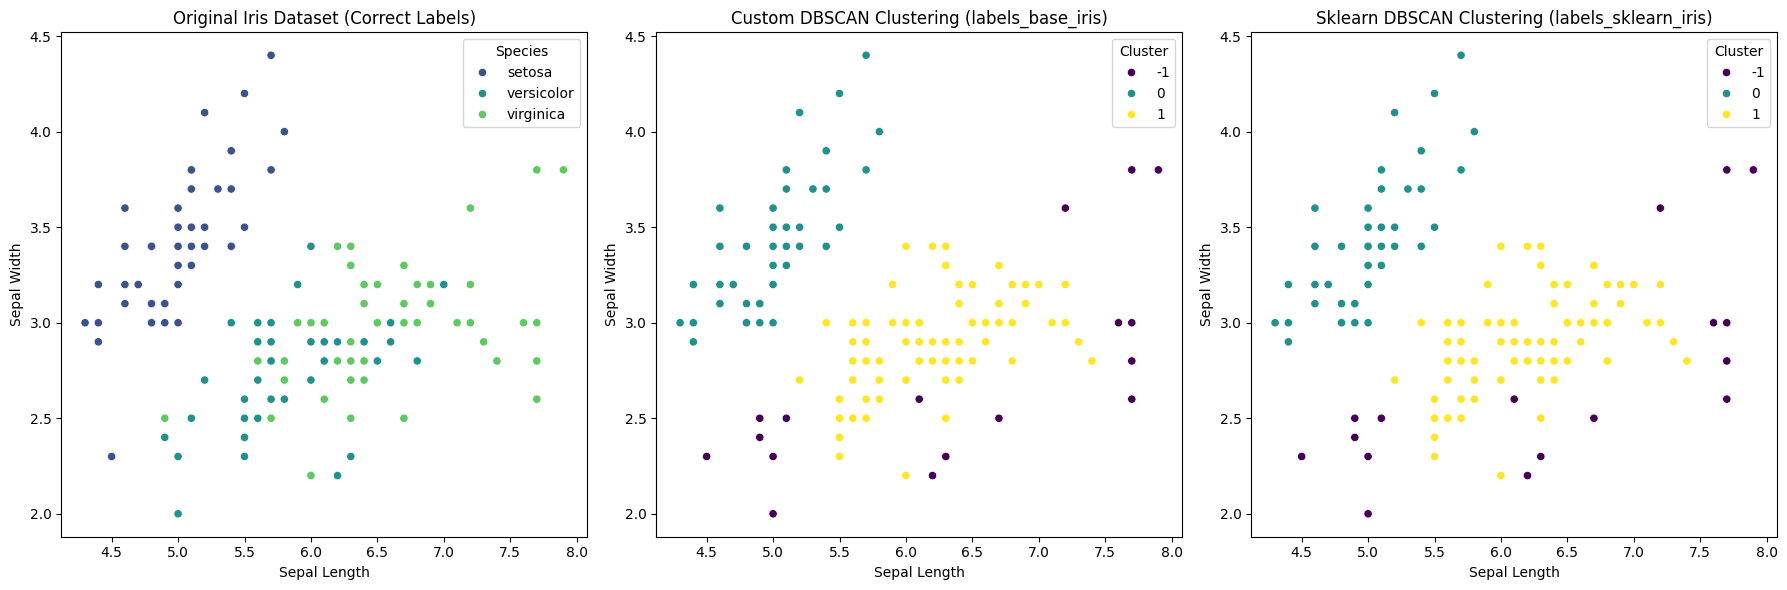

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_iris)")
axes[1].set_xlabel("Sepal Length")
axes[1].set_ylabel("Sepal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_iris)")
axes[2].set_xlabel("Sepal Length")
axes[2].set_ylabel("Sepal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [64]:
# # centroids_base_iris = scaler_iris.inverse_transform(centroids_base_iris)
# # centroids_sklearn_iris = scaler_iris.inverse_transform(centroids_sklearn_iris)

# slength_idx = list(iris_filtered.columns).index("sepal_length")
# swidth_idx = list(iris_filtered.columns).index("sepal_width")

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="pastel", s=100)
# # plt.scatter(centroids_base_iris[:, slength_idx], centroids_base_iris[:, swidth_idx], c='red', marker='x', s=150, label='Centroids (base)')
# # plt.scatter(centroids_sklearn_iris[:, slength_idx], centroids_sklearn_iris[:, swidth_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')
# # sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="pastel", s=100)

# # plt.scatter(labels_base_iris, c='red', marker='x', s=150, label='Centroids (base)')
# plt.scatter(labels_sklearn_iris, labels_sklearn_iris, c='blue')
# plt.xlabel("Sepal Length")
# plt.ylabel("Sepal Width")
# plt.title("Sepal Length vs. Sepal Width in Iris Dataset")
# plt.legend(title="Legend")
# plt.show()

def generate_plot(df, hue):
  plt.figure(figsize=(15, 15))
  sns.pairplot(df, hue=hue)
  plt.show()

# plt.figure(figsize=(15, 15))
# sns.pairplot(df.drop(['dbscan_predictions'], axis=1), hue='target')
# plt.show()

generate_plot(iris, labels_sklearn_iris)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1500x1500 with 0 Axes>

In [83]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score"])

ai_filtered = ai.select_dtypes(include=['float64'])

# scaler_ai = StandardScaler()
X_ai = ai_filtered.to_numpy()
k_ai = 3

scalar = StandardScaler()
X_ai = scalar.fit_transform(X_ai)

print("AI Global Index")

start_time = time.time()
# labels_base_ai, centroids_base_ai = k_means(X_ai, k_ai)
cluters, noise, labels_base_ai = dbscan_base(X_ai, 0.5, 5)

print(labels_base_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_ai, labels_base_ai)}")

start_time = time.time()
# kmeans_ai = KMeans(n_clusters=k_ai, random_state=seed).fit(X_ai)
# labels_sklearn_ai = kmeans_ai.labels_
# centroids_sklearn_ai = kmeans_ai.cluster_centers_

dbscan_ai = DBSCAN().fit(X_ai)

labels_sklearn_ai = dbscan_ai.labels_
print(labels_sklearn_ai)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
# print(f"Silhouette score (sklearn): {silhouette_score(X_ai, labels_sklearn_ai)}")

AI Global Index
62
[]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Execution time (base): 0.09261107444763184 seconds
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

Execution time (sklearn): 0.011086463928222656 seconds


In [89]:
# # centroids_base_ai = scaler_ai.inverse_transform(centroids_base_ai)
# # centroids_sklearn_ai = scaler_ai.inverse_transform(centroids_sklearn_ai)

# research_idx = list(ai_filtered.columns).index("Research")
# talent_idx = list(ai_filtered.columns).index("Talent")

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="pastel", s=100)
# plt.scatter(centroids_base_ai[:, research_idx], centroids_base_ai[:, talent_idx], c='red', marker='x', s=150, label='Centroids (base)')
# plt.scatter(centroids_sklearn_ai[:, research_idx], centroids_sklearn_ai[:, talent_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

# plt.xlabel("Research")
# plt.ylabel("Talent")
# plt.title("Research vs. Talent in AI Global Index dataset")
# plt.legend(title="Legend")
# plt.show()

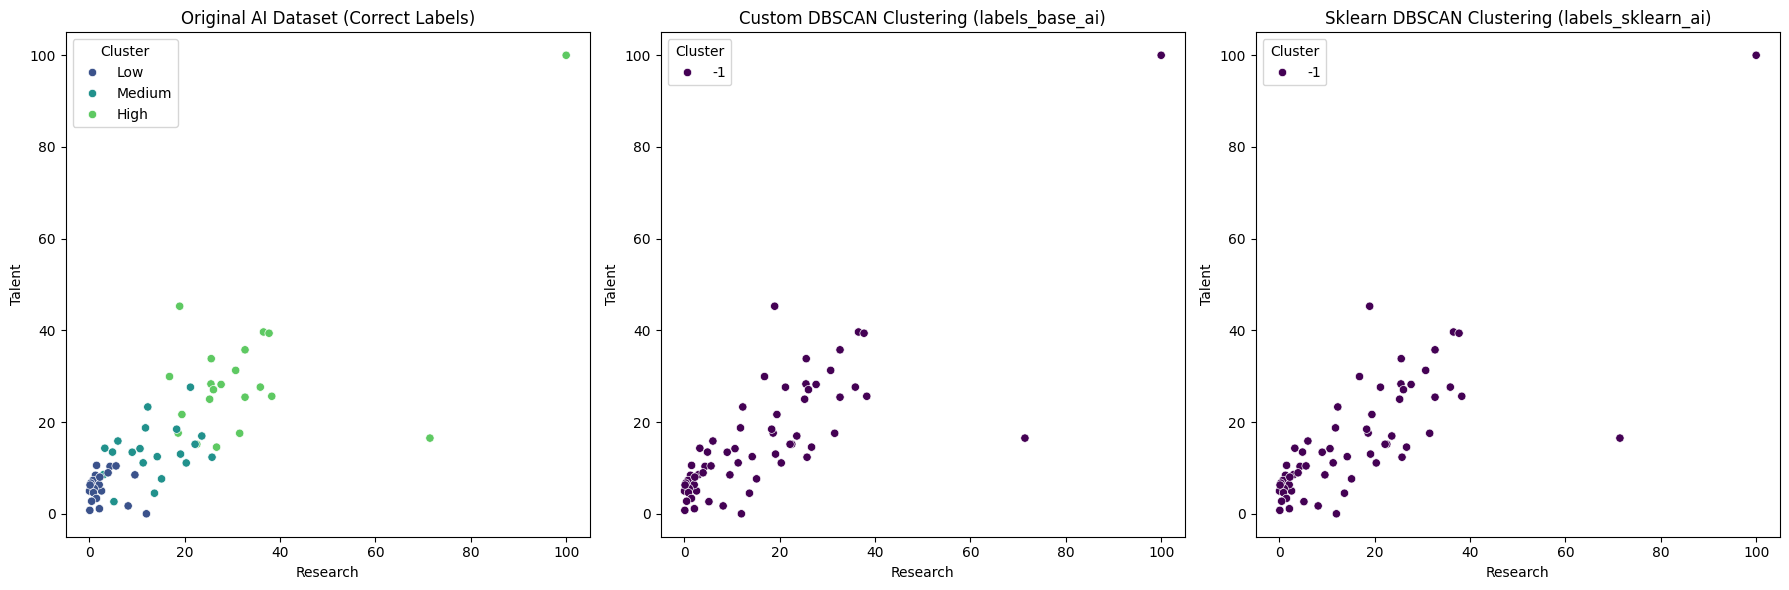

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset (Correct Labels)")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_ai)")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [6]:
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["time", "updated", "timezone", "latitude", "longitude", "tsunami", "nst", "dmin", "gap", "distanceKM", "postcode"])
earthquakes_filtered = earthquakes.select_dtypes(include=['float64', 'int64'])

X_earth = earthquakes_filtered.to_numpy()
# k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
# labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
cluters, noise, labels_base_earth = dbscan_base(X_earth, 0.5, 5)
print(labels_base_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_earth, labels_base_earth)}")

start_time = time.time()
# kmeans_earth = KMeans(n_clusters=k_earth, random_state=seed).fit(X_earth)

dbscan_earth = DBSCAN().fit(X_earth)

labels_sklearn_earth = dbscan_earth.labels_
print(labels_sklearn_earth)
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_earth, labels_sklearn_earth)}")

Global Earthquake Data
1137
[[29, 68, 379, 394, 417, 626, 835, 850, 875], [32, 67, 382, 393, 449, 593, 625, 838, 849, 903, 430, 888, 450, 904, 457, 910], [69, 94, 395, 413, 627, 651, 851, 871], [93, 412, 433, 650, 870, 891], [95, 414, 420, 652, 872, 878], [108, 109, 487, 492, 1128, 1133], [148, 195, 198, 509, 540, 543, 774, 805, 808, 976, 1020, 1023], [177, 179, 522, 524, 787, 789, 1005, 1007], [190, 196, 214, 535, 541, 559, 800, 806, 824, 1015, 1021, 1038, 1099], [193, 194, 538, 539, 803, 804, 1018, 1019], [202, 547, 812, 1027, 1103]]
[-1 -1 -1 ... -1 -1 -1]
Execution time (base): 16.764127731323242 seconds
Silhouette score (base): -0.6975647411077606
[-1 -1 -1 ... -1 -1 -1]

Execution time (sklearn): 0.015205621719360352 seconds
Silhouette score (sklearn): -0.6975647411077606


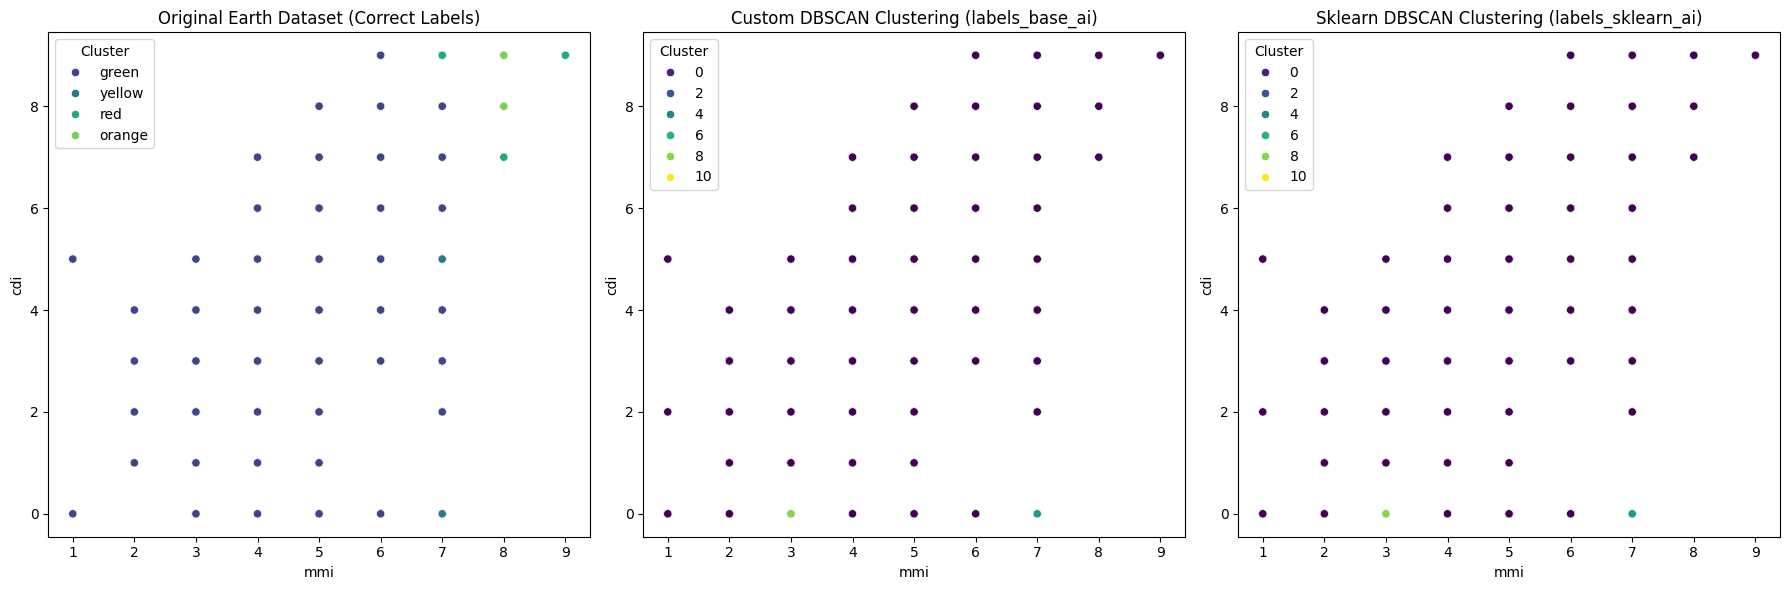

In [8]:
# cdi_idx = list(earthquakes_filtered.columns).index("cdi")
# mmi_idx = list(earthquakes_filtered.columns).index("mmi")

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
# plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, cdi_idx], c='red', marker='x', s=150, label='Centroids (base)')
# plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, cdi_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

# plt.xlabel("mmi")
# plt.ylabel("cdi")
# plt.title("mmi vs. cdi in Global Earthquake dataset")
# plt.legend(title="Legend")
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("cdi")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_ai)")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("cdi")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("cdi")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#Optics

## Doubt
- here the sklearn version essentially computes the ordered list and reachability distance
- it then uses either dbscan or xi to compute clusters

- the base version does not do this -- it simply computes clusters using a simple threshold
- how do I match this up?


In [12]:
# Optics from sklearn

'''
This implementation deviates from the original OPTICS by first performing k-nearest-neighborhood searches on all points to identify core sizes, then computing only the distances to unprocessed points when constructing the cluster order. Note that we do not employ a heap to manage the expansion candidates, so the time complexity will be O(n^2).
'''



In [17]:
# optics algorithm coded


def optics_base(df: np.ndarray, eps: int, MinPts: int):
    # Extract the features (excluding the target)
    # DB = df.drop(['target', 'species', 'dbscan_predictions', 'custom_dbscan_predictions'], axis=1).values
    DB = df
    n = len(DB)
    processed = [False] * n
    reachability_distances = [np.inf] * n
    core_distances = [np.inf] * n
    ordered_list = []

    for i in range(n):
        if not processed[i]:
            processed[i] = True
            N = get_neighbors(DB, i, eps)
            ordered_list.append(i)
            core_distances[i] = core_distance(DB, i, eps, MinPts)

            if core_distances[i] != np.inf:
                seeds = []
                update(N, i, seeds, DB, eps, MinPts, core_distances, reachability_distances)
                while seeds:
                    q = heapq.heappop(seeds)[1]
                    if not processed[q]:
                        processed[q] = True
                        N_prime = get_neighbors(DB, q, eps)
                        ordered_list.append(q)
                        core_distances[q] = core_distance(DB, q, eps, MinPts)

                        if core_distances[q] != np.inf:
                            update(N_prime, q, seeds, DB, eps, MinPts, core_distances, reachability_distances)

    return ordered_list, reachability_distances

def get_neighbors(DB, p, eps):
    neighbors = []
    for i in range(len(DB)):
        if euclidean(DB[p], DB[i]) < eps:
            neighbors.append(i)
    return neighbors

def core_distance(DB, p, eps, MinPts):
    neighbors = get_neighbors(DB, p, eps)
    if len(neighbors) < MinPts:
        return np.inf
    distances = [euclidean(DB[p], DB[i]) for i in neighbors]
    distances.sort()
    return distances[MinPts - 1]

def update(N, p, seeds, DB, eps, MinPts, core_distances, reachability_distances):
    for q in N:
        if reachability_distances[q] == np.inf:
            new_reachability_distance = max(core_distances[p], np.linalg.norm(DB[p] - DB[q]))
            if new_reachability_distance < reachability_distances[q]:
                reachability_distances[q] = new_reachability_distance
                heapq.heappush(seeds, (new_reachability_distance, q))

def extract_clusters_manual(ordered_list, reachability_distances, threshold):
    clusters = []
    current_cluster = []
    # cluster_assignments = []

    for i in range(len(ordered_list)):
        if reachability_distances[i] <= threshold:
            current_cluster.append(ordered_list[i])
        else:
            if current_cluster:
                clusters.append(current_cluster)
                current_cluster = []

    # Add the last cluster if it exists
    if current_cluster:
        clusters.append(current_cluster)

    return update_cluster_labels(len(ordered_list), clusters)

def update_cluster_labels(no_of_el, clusters):
    cluster_labels = np.full(no_of_el, -1)
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            cluster_labels[clusters[i][j]] = int(i)
    return cluster_labels

# clusters = extract_clusters_manual(ordered_list, reachability_distances, threshold)




##IRIS


In [23]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")

from sklearn.cluster import OPTICS


iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

print("Iris Dataset\n")

start_time = time.time()
ordered_list, reachability_dist = optics_base(X_iris, np.inf, 5)
labels_base_iris_optics = extract_clusters_manual(ordered_list, reachability_dist, 5)
print(ordered_list)
print(labels_base_iris_optics)

# print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_iris, labels_base_iris)}")

start_time = time.time()
optics_iris = OPTICS().fit(X_iris)
labels_sklearn_iris_optics = optics_iris.labels_

print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
# print(f"Silhouette score (sklearn): {silhouette_score(X_iris, labels_sklearn_iris)}")

Iris Dataset

[0, 4, 17, 27, 28, 39, 40, 7, 49, 21, 48, 26, 19, 46, 35, 11, 10, 31, 36, 20, 43, 9, 34, 37, 23, 2, 6, 29, 1, 30, 25, 16, 47, 12, 24, 45, 44, 5, 32, 3, 22, 18, 42, 33, 38, 14, 8, 13, 15, 41, 98, 57, 93, 79, 64, 81, 60, 80, 69, 59, 82, 88, 67, 92, 89, 99, 95, 71, 53, 96, 62, 94, 61, 90, 97, 84, 55, 74, 66, 85, 78, 106, 91, 75, 51, 87, 65, 73, 63, 58, 68, 56, 54, 70, 138, 86, 126, 50, 127, 121, 76, 72, 123, 83, 149, 119, 133, 52, 113, 101, 142, 77, 146, 110, 114, 147, 111, 134, 137, 115, 141, 116, 148, 145, 103, 139, 128, 112, 132, 136, 124, 140, 108, 104, 129, 120, 144, 143, 100, 102, 125, 130, 107, 109, 135, 131, 105, 122, 117, 118]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  0  0 -1  4  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 10 -1 10  7  9 12  0 11  9 -1  4  4  8 -

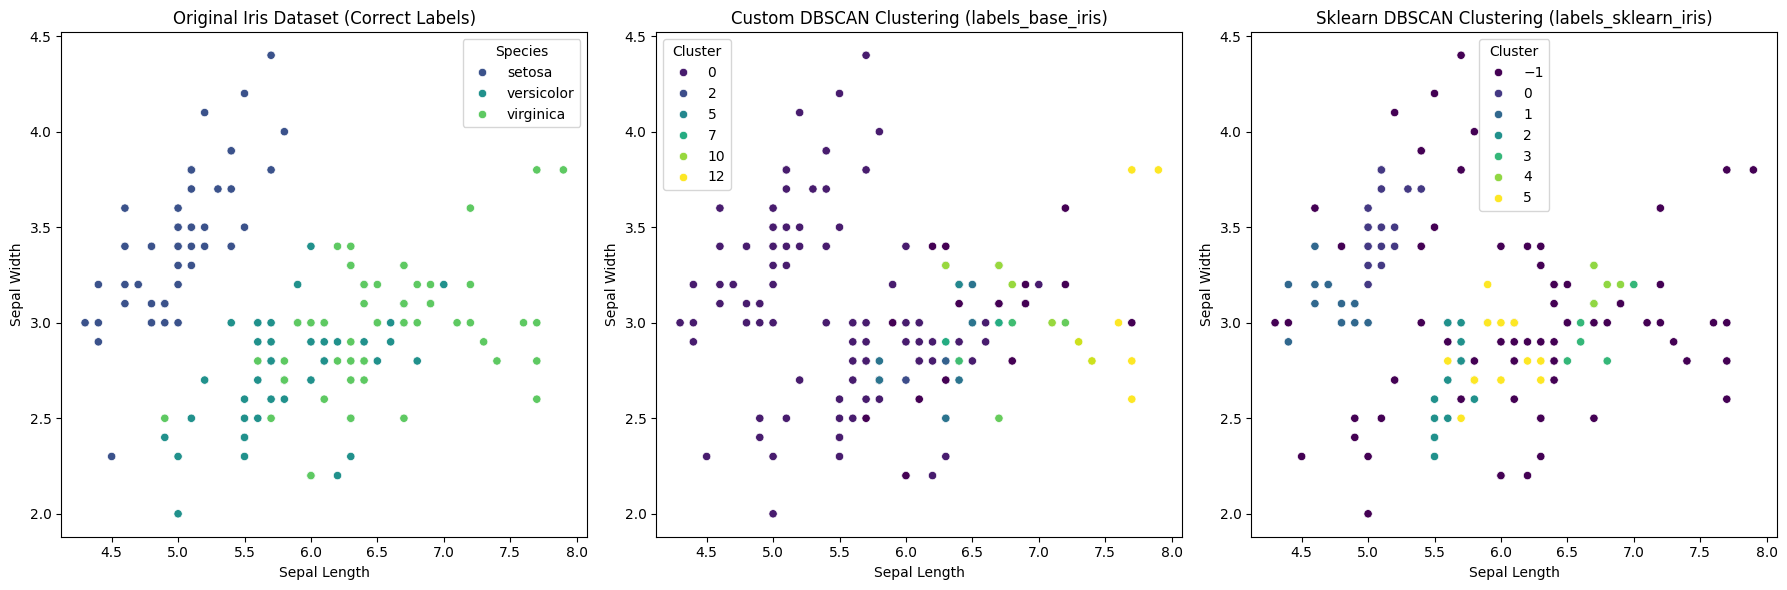

In [24]:

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris_optics, palette="viridis", ax=axes[1])
axes[1].set_title("Custom OPTICS Clustering (labels_base_iris)")
axes[1].set_xlabel("Sepal Length")
axes[1].set_ylabel("Sepal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris_optics, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn OPTICS Clustering (labels_sklearn_iris)")
axes[2].set_xlabel("Sepal Length")
axes[2].set_ylabel("Sepal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## AI


In [25]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score"])

ai_filtered = ai.select_dtypes(include=['float64'])

# scaler_ai = StandardScaler()
X_ai = ai_filtered.to_numpy()
k_ai = 3

scalar = StandardScaler()
X_ai = scalar.fit_transform(X_ai)

print("AI Global Index")

start_time = time.time()
# labels_base_ai, centroids_base_ai = k_means(X_ai, k_ai)
# cluters, noise, labels_base_ai = dbscan_base(X_ai, 0.5, 5)

ordered_list, reachability_dist = optics_base(X_ai, np.inf, 5)
labels_base_ai_optics = extract_clusters_manual(ordered_list, reachability_dist, 5)

print(labels_base_ai_optics)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_ai, labels_base_ai)}")

start_time = time.time()
# kmeans_ai = KMeans(n_clusters=k_ai, random_state=seed).fit(X_ai)
# labels_sklearn_ai = kmeans_ai.labels_
# centroids_sklearn_ai = kmeans_ai.cluster_centers_

optics_ai = OPTICS().fit(X_ai)

labels_sklearn_ai_optics = optics_ai.labels_
print(labels_sklearn_ai_optics)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
# print(f"Silhouette score (sklearn): {silhouette_score(X_ai, labels_sklearn_ai)}")

100%|██████████| 2.38k/2.38k [00:00<00:00, 4.35MB/s]

Extracting files...
AI Global Index


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Execution time (base): 0.18538784980773926 seconds
[-1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0  0 -1 -1 -1 -1 -1 -1  0  0  1 -1
 -1 -1  0 -1 -1 -1  0 -1  1 -1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1 -1
 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

Execution time (sklearn): 0.10844087600708008 seconds


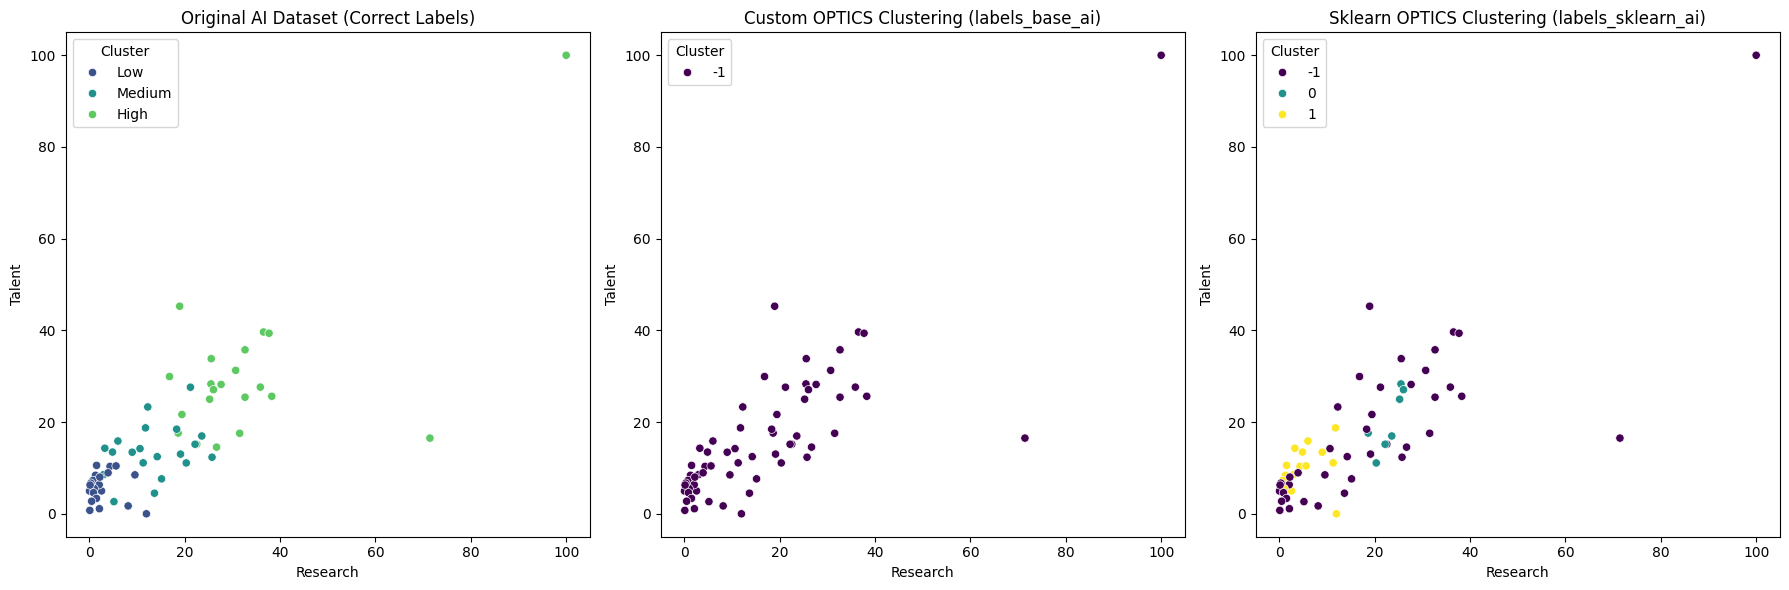

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset (Correct Labels)")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai_optics, palette="viridis", ax=axes[1])
axes[1].set_title("Custom OPTICS Clustering (labels_base_ai)")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai_optics, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn OPTICS Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Earthquakes


In [27]:
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["time", "updated", "timezone", "latitude", "longitude", "tsunami", "nst", "dmin", "gap", "distanceKM", "postcode"])
earthquakes_filtered = earthquakes.select_dtypes(include=['float64', 'int64'])

X_earth = earthquakes_filtered.to_numpy()
# k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
# labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
# cluters, noise, labels_base_earth = dbscan_base(X_earth, 0.5, 5)

ordered_list, reachability_dist = optics_base(X_earth, np.inf, 5)
labels_base_earth_optics = extract_clusters_manual(ordered_list, reachability_dist, 5)

print(labels_base_earth_optics)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_earth, labels_base_earth)}")

start_time = time.time()
# kmeans_earth = KMeans(n_clusters=k_earth, random_state=seed).fit(X_earth)

# dbscan_earth = DBSCAN().fit(X_earth)

# labels_sklearn_earth = dbscan_earth.labels_
optics_earth = OPTICS().fit(X_earth)
labels_sklearn_earth_optics = optics_earth.labels_
print(labels_sklearn_earth_optics)
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_earth, labels_sklearn_earth)}")

Global Earthquake Data
[-1 -1 -1 ... -1 -1 -1]
Execution time (base): 44.99965238571167 seconds
Silhouette score (base): -0.6975647411077606
[ 0  0  0 ... 88 -1 82]

Execution time (sklearn): 1.2601399421691895 seconds
Silhouette score (sklearn): -0.6975647411077606


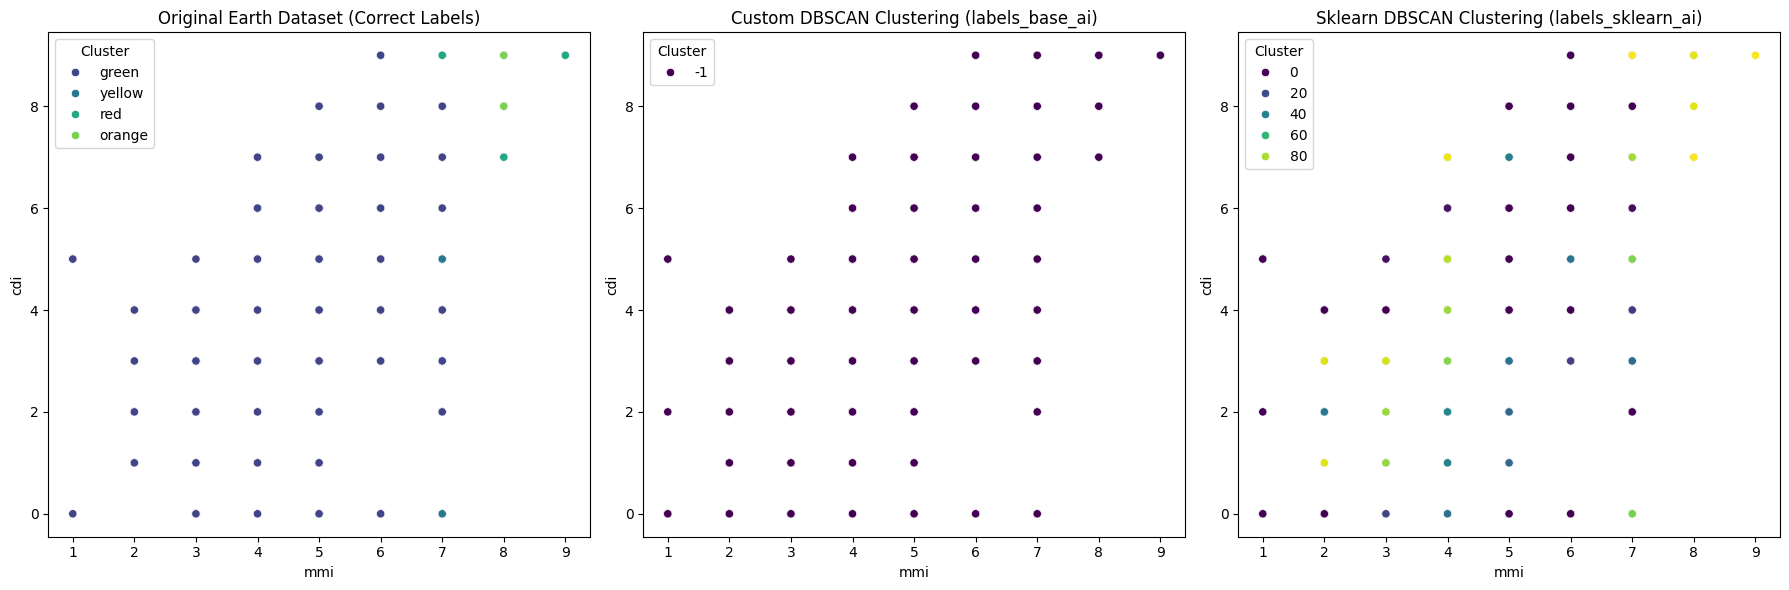

In [28]:
# cdi_idx = list(earthquakes_filtered.columns).index("cdi")
# mmi_idx = list(earthquakes_filtered.columns).index("mmi")

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
# plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, cdi_idx], c='red', marker='x', s=150, label='Centroids (base)')
# plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, cdi_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

# plt.xlabel("mmi")
# plt.ylabel("cdi")
# plt.title("mmi vs. cdi in Global Earthquake dataset")
# plt.legend(title="Legend")
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("cdi")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth_optics, palette="viridis", ax=axes[1])
axes[1].set_title("Custom OPTICS Clustering (labels_base_ai)")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("cdi")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth_optics, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn OPTICS Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("cdi")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()